In a first attempt to confirm the feasibility of our defense idea, we are going to observe the behaviour of a regular Machine Learning model when it is being poisoned. We aim to comment on the results on the reported training and testing loss produced by the model with different percentages of the dataset being poisoned, and hopefully we will be able to extract some first answers on if our plan can be carried out.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support 
from torch.utils.data import Subset

# For data vizualization 
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

from manipulate_MNIST import *
from Simple_CNN import *

%load_ext autoreload
%autoreload 2

In [2]:
# parameters for the attack
target_honest = 3
target_malicious = 8

# Honest model 1
honest1_params = {'name': "Honest 1", 'hidden_neurons': 64, 'drop_rate': 0.5, 'batch_size_train': 256, 'learning_rate': 0.001, 'epochs': 20, 'dataset_precentage': 1, 'mal_percentage': 0, 'target_honest': 0, 'target_malicious': 0}

# # Honest model 2
# honest2_params = {'name': "Honest 2", 'hidden_neurons': 64, 'drop_rate': 0.3, 'batch_size_train': 64, 'learning_rate': 0.01, 'epochs': 10, 'dataset_precentage': 0.7, 'mal_percentage': 0, 'target_honest': 0, 'target_malicious': 0}
# # Honest model 3
# honest3_params = {'name': "Honest 3", 'hidden_neurons': 256, 'drop_rate': 0.4, 'batch_size_train': 256, 'learning_rate': 0.003, 'epochs': 10, 'dataset_precentage': 0.7, 'mal_percentage': 0, 'target_honest': 0, 'target_malicious': 0}

# Malicious_model 1
mal1_params = {'name': "Malicious 1", 'hidden_neurons': 256, 'drop_rate': 0.4, 'batch_size_train': 256, 'learning_rate': 0.001, 'epochs': 20, 'dataset_precentage': 0.4, 'mal_percentage': 0.1, 'target_honest': 3, 'target_malicious': 8}

# Malicious_model 2
mal2_params = {'name': "Malicious 2", 'hidden_neurons': 256, 'drop_rate': 0.4, 'batch_size_train': 256, 'learning_rate': 0.001, 'epochs': 20, 'dataset_precentage': 0.4, 'mal_percentage': 0.2, 'target_honest': 3, 'target_malicious': 8}

# Malicious_model 3
mal3_params = {'name': "Malicious 3", 'hidden_neurons': 256, 'drop_rate': 0.4, 'batch_size_train': 256, 'learning_rate': 0.001, 'epochs': 20, 'dataset_precentage': 0.4, 'mal_percentage': 0.3, 'target_honest': 3, 'target_malicious': 8}

# Malicious_model 4
mal4_params = {'name': "Malicious 4", 'hidden_neurons': 256, 'drop_rate': 0.4, 'batch_size_train': 256, 'learning_rate': 0.001, 'epochs': 20, 'dataset_precentage': 0.4, 'mal_percentage': 0.4, 'target_honest': 3, 'target_malicious': 8}

# Malicious_model 5
mal5_params = {'name': "Malicious 5", 'hidden_neurons': 256, 'drop_rate': 0.4, 'batch_size_train': 256, 'learning_rate': 0.001, 'epochs': 20, 'dataset_precentage': 0.4, 'mal_percentage': 0.5, 'target_honest': 3, 'target_malicious': 8}

# Malicious_model 6
mal6_params = {'name': "Malicious 6", 'hidden_neurons': 256, 'drop_rate': 0.4, 'batch_size_train': 256, 'learning_rate': 0.001, 'epochs': 20, 'dataset_precentage': 0.4, 'mal_percentage': 0.6, 'target_honest': 3, 'target_malicious': 8}

# Malicious_model 7
mal7_params = {'name': "Malicious 7", 'hidden_neurons': 256, 'drop_rate': 0.4, 'batch_size_train': 256, 'learning_rate': 0.001, 'epochs': 20, 'dataset_precentage': 0.4, 'mal_percentage': 0.7, 'target_honest': 3, 'target_malicious': 8}

models_small = [honest1_params, mal1_params, mal2_params, mal3_params]


models = [honest1_params, mal1_params, mal2_params, mal3_params, mal4_params, mal5_params, mal6_params, mal7_params]

In [3]:
# Define the training data pipeline
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# get the original dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [4]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for model in models:
    
    trainset = generate_malicious_dataset(trainset, model['mal_percentage'], model['target_honest'], model['target_malicious'])
    # Create the subset dataset
    new_size = int(len(trainset) * model['dataset_precentage'])
    subset_dataset = Subset(trainset, list(range(new_size)))

    # load it to the trainloader for training
    model['trainloader'] = torch.utils.data.DataLoader(subset_dataset, batch_size=model['batch_size_train'], 
    shuffle=True, num_workers=2)

    cnn = SimpleCNN(model['hidden_neurons'], model['drop_rate']).to(device)
    model['model'] = cnn
    model['losses'] = []

In [5]:

criterion = nn.CrossEntropyLoss().to(device)
cnn = SimpleCNN(model['hidden_neurons'], model['drop_rate']).to(device)
for e in range(models[0]['epochs']):

    for i, model in enumerate(models):
        optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)
        # for honest models, train the epoch with the original, honest data
        if ("Honest" in model['name']):
            epoch_loss, precision, recall, f1_score = train_epoch(optimizer, cnn, models[0]['trainloader'], criterion, device)
            print("\nEpoch: ", e, " loss: ", round(epoch_loss,4), " precision: ", round(precision, 4), " recall: ", round(recall, 4), " f1_score ", round(f1_score, 4))
            models[0]['losses'].append(epoch_loss)
            # for malicious models, test (pass without backprobagating) the train model
            # this is a train simulation but without
        else:
            epoch_loss = predict_test(cnn, model['trainloader'], device, criterion)
            print(model['name'] + ": " + str(epoch_loss))
            model['losses'].append(epoch_loss)

100%|██████████| 235/235 [00:05<00:00, 40.44it/s]
Epoch:  0  loss:  1.4799  precision:  0.5857  recall:  0.583  f1_score  0.5579

Malicious 1: 1.4440001249313354
Malicious 2: 1.4105886220932007
Malicious 3: 1.507705807685852
Malicious 4: 1.5190755128860474
Malicious 5: 1.4905356168746948
Malicious 6: 1.5787330865859985
Malicious 7: 1.6062501668930054
100%|██████████| 235/235 [00:05<00:00, 45.70it/s]
Epoch:  1  loss:  0.6706  precision:  0.7997  recall:  0.7987  f1_score  0.7919

Malicious 1: 0.6161885261535645
Malicious 2: 0.7837786674499512
Malicious 3: 0.6956338882446289
Malicious 4: 0.8880599141120911
Malicious 5: 0.9549219012260437
Malicious 6: 0.9624477028846741
Malicious 7: 1.0082697868347168
100%|██████████| 235/235 [00:05<00:00, 45.75it/s]
Epoch:  2  loss:  0.4047  precision:  0.8733  recall:  0.8764  f1_score  0.8662

Malicious 1: 0.5128335356712341
Malicious 2: 0.6908500790596008
Malicious 3: 0.7339888215065002
Malicious 4: 0.7086682319641113
Malicious 5: 0.8164371848106384
M

# Graph 1
For each malicious trainer, plotting the loss 

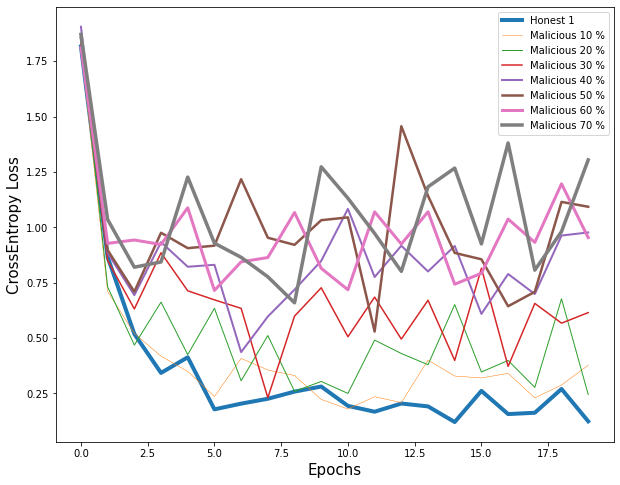

In [28]:
epochs = [i for i in range(20)]

plt.figure(figsize=(10, 8))
for i, model in enumerate(models):
    if "Honest" in model['name']:
        plt.plot(epochs, model['losses'], label=model['name'], linewidth = 4)
    else:
        # diff_losses = model['losses'][1:-1] + [0]
        # res = [model['losses'][i] - diff_losses[i] for i in range(len(diff_losses))]
        # plt.plot(epochs, res, label=model['name'])
        plt.plot(epochs, model['losses'], label=model['name'] + "0 %", linewidth = 0.5 * i)

        
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("CrossEntropy Loss", fontsize=15)
plt.legend()
plt.show()

## Graph 2: 
For each malicious trainer, display the distance of its training loss from the original one

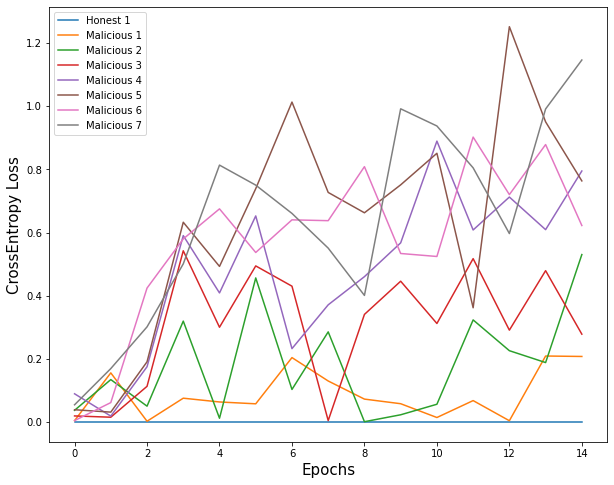

In [29]:
epochs = [i for i in range(15)]

dists = {}

honest_model = models[0]

plt.figure(figsize=(10, 8))
for model in models:
    model['dist_graph1'] = [abs(model['losses'][i] - honest_model['losses'][i])  for i in range(15)]
    plt.plot(epochs, model['dist_graph1'], label = model['name'])

plt.xlabel("Epochs", fontsize=15)
plt.ylabel("CrossEntropy Loss", fontsize=15)
plt.legend()
plt.show()

# Graph 3

Mean loss (with respect to epochs) for each model

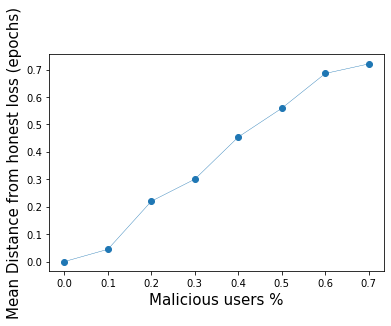

In [68]:
x = [i/10 for i in range(8)]

mean_loss = []

honest_model = models[0]

for model in models:
    n = 0
    for j in range(15):
        n += (model['losses'][j] - honest_model['losses'][j])
    
    model['dist_graph2'] = n / 15
    mean_loss.append(model['dist_graph2'])

plt.plot(x, mean_loss, 'o', linestyle = "-", linewidth = .4)

plt.xlabel("Malicious users %", fontsize=15)
plt.ylabel("Mean Distance from honest loss (epochs)", fontsize=15)
plt.show()